In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

import matplotlib.patches as mpatches


import session_config
import reports
import userdisplay
import geospatial
import gridforecast as gfcast
import datetime as dt
from IPython.display import Markdown

import logging

logging.basicConfig(
    filename='app.log', 
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

color_style = {'prior':'color: #daa520', 'likelihood':'color: #1e90ff'}
palette = {'prior':'goldenrod', 'likelihood':'dodgerblue'}

In [39]:
data = session_config.collect_survey_data()

o_dates = {'start':'2020-01-01', 'end':'2021-12-31'}
prior_dates = {'start':'2015-11-15', 'end':'2019-12-31'}

# all data
canton = 'Bern'
d= data.reset_index(drop=True)
# make complete report
river_params = {'canton':canton, 'date_range':o_dates, 'feature_type': 'l'}
river_params_p = {'canton':canton, 'date_range':prior_dates, 'feature_type':'l'}

# set the parameters for the weighted prior
# exclude records in the likelihood, set date range and feature type
o_prior_r = d[(d.canton != canton)&(d['date'] <= o_dates['end'])&(d.feature_type == 'l')].copy()
o_report_r, o_land_use_r = gfcast.make_report_objects(o_prior_r)

newd = o_land_use_r.df_cat.copy()
newd['feature_type'] = 'l'

args = {
    'likelihood': river_params,
    'prior' : river_params_p,
    'data' : d,
    'logger' : logger,
    'land-use-inventory' : newd.copy(),
}

results = gfcast.reports_and_forecast(args['likelihood' ], args['prior'], ldata=args['data'], logger=args['logger'], other_data=args['land-use-inventory'])
results

{'this_report': <reports.SurveyReport at 0x722b88c71310>,
 'this_land_use': <geospatial.LandUseReport at 0x722b9aba2a90>,
 'prior_report': <reports.SurveyReport at 0x722b9b53de80>,
 'prior_land_use': <geospatial.LandUseReport at 0x722c07d21be0>,
 'posterior_no_limit': <gridforecast.MulitnomialDirichlet at 0x722c27ea0700>,
 'posterior_99': array([0.01, 0.01, 1.  , 2.  , 7.  , 4.  , 2.  , 3.  , 2.  , 4.  , 2.  ,
        4.  , 2.  , 2.  , 4.  , 5.  , 1.  , 1.  , 2.  , 2.  , 1.  , 0.01,
        0.01, 2.  , 2.  , 0.01, 1.  , 2.  , 0.01, 2.  , 0.01, 3.  , 2.  ,
        2.  , 4.  , 2.  , 0.01, 0.01, 1.  , 0.01, 2.  , 0.01, 0.01, 1.  ,
        0.01, 0.01, 1.  , 0.01, 0.01, 1.  , 1.  , 2.  , 1.  , 0.01, 0.01,
        3.  , 0.01, 0.01, 0.01, 1.  , 1.  , 0.01, 0.01, 0.01, 1.  , 0.01,
        0.01, 0.01, 2.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1.  , 0.01,
        0.01, 0.01, 0.01, 0.01, 1.  , 0.01, 1.  , 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1.  , 0.01, 0.01, 1.  , 

In [3]:
# if no likelihood and no prior

display_results = [ 
    'weighted-forecast', 
    'observed-max-forecast',
    'observed-99-forecast',
    'proportion-most-common',
    'most-common-objects',
    'sampling-summary',
    'prior-sampling-summary',
    'observed-values',
    'forecasted-values',
    'likelihood-labels',
    'prior-labels'
]

display_r = {x: 'No data' for x in display_results}

def display_forecast(fcast_summary):
    average = fcast_summary['average']
    hdi_min, hdi_max = fcast_summary['hdi'][0], fcast_summary['hdi'][1]
    
    range_90_min, range_90_max= fcast_summary['range'][0], fcast_summary['range'][-1]
    alist = f'\n* Average: {round(average, 2)}\n* HDI 95%: {round(hdi_min, 2)} - {round(hdi_max, 2)}\n* 90% Range: {round(range_90_min, 2)} - {round(range_90_max,2)}'
    return alist
def labels_for_display(args):
    start = args['date_range']['start'][:4]
    end = args['date_range']['end'][:4]
    labels = f"{start} - {end}"
    return labels

def display_forecast_summary(asummary, label):
    forecast_summary = display_forecast(asummary)
    forecast_summary = Markdown(f'{label}{forecast_summary}')
    return forecast_summary

def sampling_summary_markdown(labels, summary: dict = None, language: str = 'en'):
            p_header = f"<font color=#daa520>{labels}</font>"
            if summary is not None:
                p_info = userdisplay.sampling_result_summary(summary, session_language=language)[1]
            else:
                p_info = '* No data for the period requested\n'
            p_samp_sum = Markdown(f'{p_header}\n{p_info}')
            return p_samp_sum

if results['this_report'] == 'No likelihood':

    def assemble_sampling_summary():
            pass
    
    # make the labels for display
    likelihood_labels = labels_for_display(args['likelihood'])
    

    # make the display text
    l_samp_sum = sampling_summary_markdown(likelihood_labels)

    # update display object
    display_r.update({'sampling-summary': l_samp_sum, 'likelihood-labels' : likelihood_labels})
    
    # their is no data in the query   
    if results['prior_report'] == 'No prior':

        def assemble_sampling_summary():
            pass
        # make the labels for display
        prior_labels = labels_for_display(args['prior'])

        # # make the display text
        p_samp_sum = sampling_summary_markdown(prior_labels)

        # up date the prior report attributes of the results object
        results.update({'prior_report':'No prior data'})
        
       # update display object
        display_r.update({'prior-sampling-summary' : p_samp_sum,'prior-labels': prior_labels})
    
    # if no likelihood and there is prior data for the region
    else:

        def assemble_sampling_summary():
            pass
        
        p_summary = results['prior_report'].sampling_results_summary.copy()
        prior_labels = labels_for_display(args['prior'])
        # display for sampling summary
        p_samp_sum = sampling_summary_markdown(prior_labels, summary=p_summary)

        def assemble_observed_values():
            pass
        
        observedvals = [(results['prior_report'].sample_results['pcs/m'], prior_labels, palette['prior'])]

        def make_a_weighted_forecast():
            pass
        weighted_args = [results['this_land_use'], session_config.feature_variables, args['land-use-inventory'], results['prior_report'].sample_results['pcs/m']]
        weighted_forecast, weighted_posterior, weighted_summary, selectedr = gfcast.forecast_weighted_prior(*weighted_args)
        # display weighted_forecast
        forecast_weighted = display_forecast_summary(weighted_summary, '__Given the weighted prior__')
        
        def assemble_forecasts():
            pass
        forecasts = [
            (results['prior_report'].sample_results['pcs/m'], labels_r, '-', palette['prior']),
            (weighted_forecast, 'forecast weighted prior', '-.', 'black'),
        ]
        
        display_r.update({
                'weighted-forecast':forecast_weighted,
                'prior-sampling-summary' : p_samp_sum,
                'observed-values' : observedvals,
                'forecasted-values' : forecasts,
                'prior-labels' :prior_labels,                
            })       

            
else:

    def assemble_sampling_summary():
            pass
    l_summary = results['this_report'].sampling_results_summary.copy()
    likelihood_labels = labels_for_display(args['likelihood'])
    # make the display text
    l_samp_sum = sampling_summary_markdown(likelihood_labels, summary=l_summary)

    def assemble_most_common():
        pass
    
    # most common objects the likelihood data
    object_inventory = results['this_report'].object_summary()
    object_inventory.reset_index(drop=False, inplace=True)
    most_common_objects, mc_codes, proportions = userdisplay.most_common(object_inventory)
    most_common_objects = most_common_objects.set_caption("")
    ratio_most_common = Markdown(f'__The most common objects account for {int(proportions*100)}% of all objects__')
    
    display_r.update({
    'proportion-most-common' : ratio_most_common,
    'most-common-objects' : most_common_objects,
    'sampling-summary' : l_samp_sum})
    
    if results['prior_report'] == 'No prior':

        def assemble_sampling_summary():
            pass
        # start = args['prior']['date_range']['start'][:4]
        # end = args['prior']['date_range']['end'][:4]  
        prior_labels =labels_for_display(args['prior'])
        
        # # make the display text
        p_samp_sum = sampling_summary_markdown(prior_labels)
        
        
        # forecast_maxval =  Markdown('__Given the observed max__\n* No prior data to consider see weighted prior\n')
        # forecast_99 = Markdown('__Given the observed 99__\n* No prior data to consider see weighted prior\n')

        def assemble_observed_values():
            pass
        
        observedvals =  [
            (results['this_report'].sample_results['pcs/m'], likelihood_labels, palette['likelihood'])
        ]

        def make_a_weighted_forecast():
            pass
        
        weighted_args = [results['this_land_use'], session_config.feature_variables, args['land-use-inventory'], results['this_report'].sample_results['pcs/m']]
        weighted_forecast, weighted_posterior, weighted_summary, selected = gfcast.forecast_weighted_prior(*weighted_args)
        forecast_weighted = display_forecast_summary(weighted_summary, '__Given the weighted prior__')

        def assemble_forecasts():
            pass
        forecasts = [
            (selected['pcs/m'], 'random weighted samples', '--', palette['prior']),
            (results['this_report'].sample_results['pcs/m'], likelihood_labels, '-',palette['likelihood']),               
            (weighted_forecast, 'forecast weighted prior', '-.', 'black'),
        ]
        
        display_r.update({
            'weighted-forecast':forecast_weighted,
            'forecasted-values' : forecasts,
            # 'observed-max-forecast': forecast_maxval,
            # 'observed-99-forecast' : forecast_99,                
            'prior-sampling-summary' : p_samp_sum,
            'observed-values' : observedvals,
            'likelihood-labels' : likelihood_labels,
            'prior-labels' :prior_labels ,
            
        })
        
    else:

        def assemble_sampling_summary():
            pass
    
        p_summary = results['prior_report'].sampling_results_summary.copy()
        prior_labels = labels_for_display(args['prior'])
        p_samp_sum = sampling_summary_markdown(prior_labels, summary=p_summary)

        def make_max_val_forecast():
            pass
        
        xii = results['posterior_no_limit'].sample_posterior()
        
        forecast_maxval = display_forecast_summary(results['posterior_no_limit'].get_descriptive_statistics(), '__Given the observed max__')
        observedvals =  [
            
            (results['this_report'].sample_results['pcs/m'], likelihood_labels, palette['likelihood'])
        ]
        # limit to the 99th percentile
        def make_99th_val_forecast():
            pass
        sample_values, posterior, summary_simple = gfcast.dirichlet_posterior(results['posterior_99'])
        forecast_99 = display_forecast_summary(summary_simple, '__Given the 99th percentile__')


        def make_a_weighted_forecast():
            pass
        
        weighted_args = [results['this_land_use'], session_config.feature_variables, args['land-use-inventory'], results['this_report'].sample_results['pcs/m']]
        weighted_forecast, weighted_posterior, weighted_summary, selectedr = gfcast.forecast_weighted_prior(*weighted_args)
        forecast_weighted = display_forecast_summary(weighted_summary, '__Given the weighted prior__')


        def assemble_forecasts():
            pass
        
        forecasts = [
            (results['prior_report'].sample_results['pcs/m'], prior_labels, '-',palette['prior']),
            (results['this_report'].sample_results['pcs/m'], likelihood_labels, '-',palette['likelihood']),
            (sample_values, 'expected 99th', '-', 'blue'),
            (xii, 'observed max', ':', 'red'),
            (weighted_forecast, 'weighted prior', '-.', 'black')
        ]
        
        display_r = {
            'weighted-forecast':forecast_weighted,
            'observed-max-forecast': forecast_maxval,
            'observed-99-forecast' : forecast_99,
            'proportion-most-common' : ratio_most_common,
            'most-common-objects' : most_common_objects,
            'sampling-summary' : l_samp_sum,
            'prior-sampling-summary' : p_samp_sum,
            'observed-values' : observedvals,
            'forecasted-values' : forecasts,
            'likelihood-labels' : likelihood_labels,
            'prior-labels' :prior_labels ,
            
        } 
        


In [4]:
# import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
# import matplotlib.pyplot as plt
# import numpy as np
import graphviz

# Load your data
# code groups

# from use_cases example
ooi = ['G10',  'Gcaps', 'G30', 'G31', 'G33', 'G34', 'G35', 'G8', 'G7', 'G6', 'G5', 'G4', 'G37', 'G2', 'G27', 'G25']

tobo_snacks = ['G27', 'G25', 'G30', 'G35']

# unidentified
udi = ['Gfrags', 'Gfoams', 'Gcaps']

# industrial
indus = ['G89', 'G67', 'G112', 'G93' , 'G66' 'G74', 'G72']
# &(d.canton == canton)
# &(d.canton == canton)
o_prior_x = d[(d['date'] <= o_dates['end'])&(d.feature_type == 'l')&(d.canton == canton)].copy()
o_prior_x = o_prior_x[o_prior_x.code.isin(tobo_snacks)].copy()
o_report_rx, o_land_use_rx = gfcast.make_report_objects(o_prior_x)
datax = o_land_use_rx.df_cont.copy()

# Prepare the data
X_corrected = datax.drop(columns=['sample_id', 'location', 'date', 'pcs/m', 'quantity'])
y = datax['pcs/m']



# Get the names of the selected features
selected_features = session_config.feature_variables
X_corrected = X_corrected[selected_features]

# selected_features = X_corrected.columns[selector.get_support()]

# print("Selected features:", selected_features)
# X_train_corr = X_train_corr[selected_features]
# X_test_corr = X_test_corr[selected_features]

# Split the data into training and testing sets
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corrected, y, test_size=0.2, random_state=42)

# Select the top 5 features
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_corrected, y)

In [5]:
dti = datax.drop(['sample_id', 'location', 'date', 'quantity', 'orchards_forest', 'buildings_public services'], axis=1)
dti.to_csv("ml_ops.csv", index=False)

In [6]:
datax.columns

Index(['sample_id', 'location', 'date', 'quantity', 'pcs/m', 'public services',
       'streets', 'orchards', 'vineyards', 'buildings', 'forest', 'undefined',
       'orchards_forest', 'buildings_public services'],
      dtype='object')

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


r2_max = 0
model_type = "" 


# Train a decision tree regressor
dt_regressor_corr = DecisionTreeRegressor(random_state=42)
dt_regressor_corr.fit(X_train_corr, y_train_corr)

# Predict on the test set
y_pred_corr = dt_regressor_corr.predict(X_test_corr)

# Evaluate the model
mse_corr = mean_squared_error(y_test_corr, y_pred_corr)
r2_corr = r2_score(y_test_corr, y_pred_corr)
if r2_corr > r2_max:
    r2_max = r2_corr
    selected_model = dt_regressor_corr
    model_type = "Decisiion tree"
    

# print("Decisiion tree MSE:", mse_corr)
# print("Decision tree R2:", r2_corr)

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_corr, y_train_corr)
y_pred_rf = rf_model.predict(X_test_corr)
mse_rf = mean_squared_error(y_test_corr, y_pred_rf)
r2_rf = r2_score(y_test_corr, y_pred_rf)

if r2_rf > r2_max:
    r2_max = r2_rf
    selected_model = rf_model
    model_type = 'Random Forest Regression' 
# print("Random Forest Regression MSE:", mse_rf)
# print("Random Forest Regression R²:", r2_rf)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_corr, y_train_corr)
y_pred_gb = gb_model.predict(X_test_corr)
mse_gb = mean_squared_error(y_test_corr, y_pred_gb)
r2_gb = r2_score(y_test_corr, y_pred_gb)

if r2_gb > r2_max:
    r2_max = r2_gb
    selected_model = gb_model
    model_type = 'Gradient Boosting Regression' 
# print("Gradient Boosting Regression MSE:", mse_gb)
# print("Gradient Boosting Regression R²:", r2_gb)

# Support Vector Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_corr)
X_test_scaled = scaler.transform(X_test_corr)
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train_corr)
y_pred_svr = svr_model.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test_corr, y_pred_svr)
r2_svr = r2_score(y_test_corr, y_pred_svr)

if r2_svr > r2_max:
    r2_max = r2_svr
    selected_model = svr_model
    model_type = 'Support Vector' 
# print("Support Vector Regression MSE:", mse_svr)
# print("Support Vector Regression R²:", r2_svr)

from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
rf_grid_search.fit(X_train_corr, y_train_corr)
best_rf = rf_grid_search.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_corr)
mse_rf_tuned = mean_squared_error(y_test_corr, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test_corr, y_pred_rf_tuned)


if r2_rf_tuned > r2_max:
    r2_max = r2_rf_tuned
    selected_model = best_rf
    model_type = "Tuned Random Forest"
# print("Tuned Random Forest MSE:", mse_rf_tuned)
# print("Tuned Random Forest R²:", r2_rf_tuned)



from sklearn.ensemble import StackingRegressor, VotingRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR(kernel='rbf'))
]

# Define stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
stacking_model.fit(X_train_corr, y_train_corr)
y_pred_stacking = stacking_model.predict(X_test_corr)
mse_stacking = mean_squared_error(y_test_corr, y_pred_stacking)
r2_stacking = r2_score(y_test_corr, y_pred_stacking)

if r2_stacking > r2_max:
    r2_max = r2_stacking
    selected_model = stacking_model
    model_type = "Stacking model"
# print("Stacking Model MSE:", mse_stacking)
# print("Stacking Model R²:", r2_stacking)

# Define voting model
voting_model = VotingRegressor(estimators=base_models)
voting_model.fit(X_train_corr, y_train_corr)
y_pred_voting = voting_model.predict(X_test_corr)
mse_voting = mean_squared_error(y_test_corr, y_pred_voting)
r2_voting = r2_score(y_test_corr, y_pred_voting)

if r2_voting > r2_max:
    r2_max = r2_voting
    selected_model = voting_model
    model_type = "Voting model"
# print("Voting Model MSE:", mse_voting)
# print("Voting Model R²:", r2_voting)

# import pandas as pd
# from sklearn.model_selection import train_test_split
import statsmodels.api as sm
poisson_model = sm.GLM(y_train_corr, X_train_corr, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Calculate the Pearson Chi-Square dispersion
dispersion = poisson_results.pearson_chi2 / poisson_results.df_resid

# Fit a negative binomial model
model = sm.GLM(y_train_corr, X_train_corr, family=sm.families.NegativeBinomial(alpha=dispersion))
nb_results = model.fit()

# Predict on the test set
y_pred_nb = nb_results.predict(X_test_corr)

# Evaluate the model
mse_nb = mean_squared_error(y_test_corr, y_pred_nb)
r2_nb = r2_score(y_test_corr, y_pred_nb)

if r2_nb > r2_max:
    r2_max = r2_nb
    selected_model = nb_results
    model_type = "Negative Binomial Regression"

print(model_type)
print(r2_max)

Tuned Random Forest
0.6204225401378242


In [28]:
X_corrected[selected_features].shape[1]

7

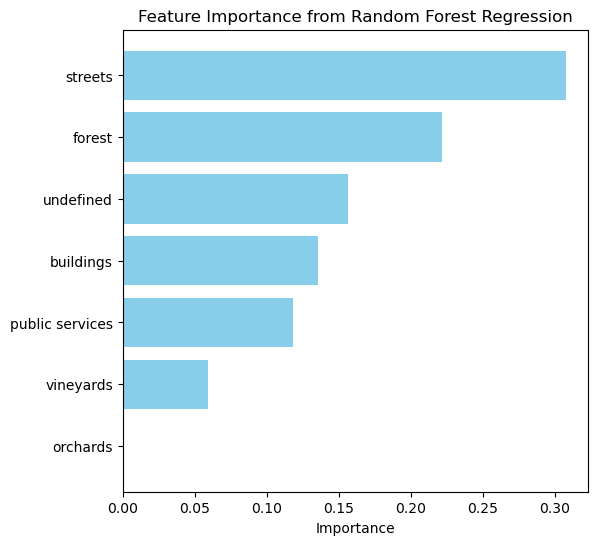

In [29]:
# Get feature importances from the corrected decision tree model

y_pred_rf_tuned = selected_model.predict(X_test_corr)
importances_corr = selected_model.feature_importances_
indices_corr = np.argsort(importances_corr)[::-1]

feature_importances = selected_model.feature_importances_
feature_names = X_corrected.columns

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(6,6))
# Visualize the decision tree
# dot_data = export_graphviz(selected_model, out_file=None, 
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Regression')
plt.gca().invert_yaxis()
plt.show()



In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Extract features and target variable
features = X_corrected 
target = y

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# # Determine the optimal number of clusters using the Elbow Method
# inertia = []
# k_range = range(1, 11)

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(scaled_features)
#     inertia.append(kmeans.inertia_)

# # Plot the Elbow Method graph
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, inertia, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.grid(True)
# plt.show()


In [31]:
# Apply K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)


dataxi = datax[['pcs/m', *selected_features]].copy()

# Add cluster labels to the original data
dataxi['Cluster'] = cluster_labels

# Analyze the clusters
cluster_analysis = dataxi.groupby('Cluster').mean()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Cluster Analysis", dataframe=cluster_analysis)

cluster_analysis.style.set_table_styles(userdisplay.table_css_styles).format(precision=2)


,pcs/m,orchards,vineyards,buildings,forest,undefined,public services,streets
Cluster,,,,,,,,
0,0.07,0.14,0.00,0.16,0.56,0.14,0.00,0.14
1,0.39,0.00,0.02,0.24,0.20,0.54,0.01,0.17
2,0.37,0.00,0.00,0.83,0.08,0.08,0.05,0.25
3,1.64,0.00,0.00,0.47,0.35,0.19,0.03,0.32


In [32]:
# Bar chart of feature values by cluster
cluster_means =dataxi.groupby('Cluster', as_index=False).mean().drop(columns=['pcs/m'])
cluster_means = pd.melt(cluster_means, id_vars=['Cluster'], value_vars=cluster_means.columns[0:])


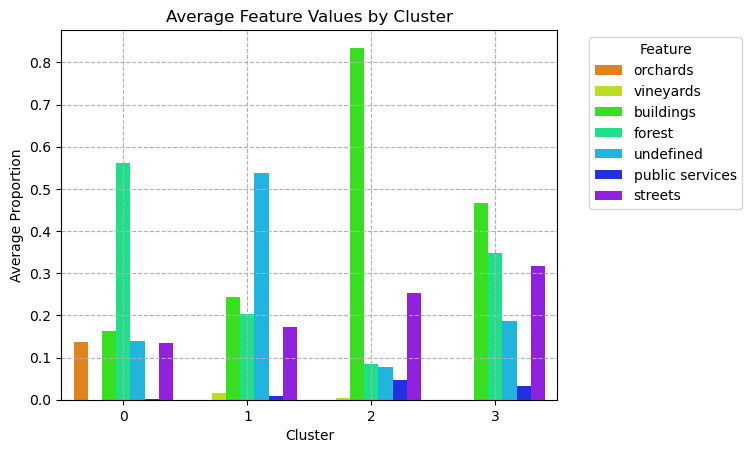

In [33]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_cycle = sns.color_palette(custom_colors)
# Custom color palette
custom_palette = sns.color_palette("gist_rainbow", n_colors=len(cluster_means['variable'].unique()))


# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
# plt.rcParams['figure.figsize'] = (10, 6)
# plt.rcParams['axes.titlesize'] = 'large'
# plt.rcParams['axes.labelsize'] = 'medium'
# plt.rcParams['xtick.labelsize'] = 'medium'
# plt.rcParams['ytick.labelsize'] = 'medium'
# plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['grid.linestyle'] = '--'

sns.barplot(data=cluster_means, x=cluster_means.Cluster, y=cluster_means.value, hue=cluster_means.variable, palette=custom_palette)
plt.xlabel('Cluster')
plt.ylabel('Average Proportion')
plt.title('Average Feature Values by Cluster')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [34]:
buildings_stats = dataxi.groupby('Cluster')['buildings'].describe()
dataxi.Cluster.value_counts()

Cluster
1    68
3    20
2     5
0     5
Name: count, dtype: int64

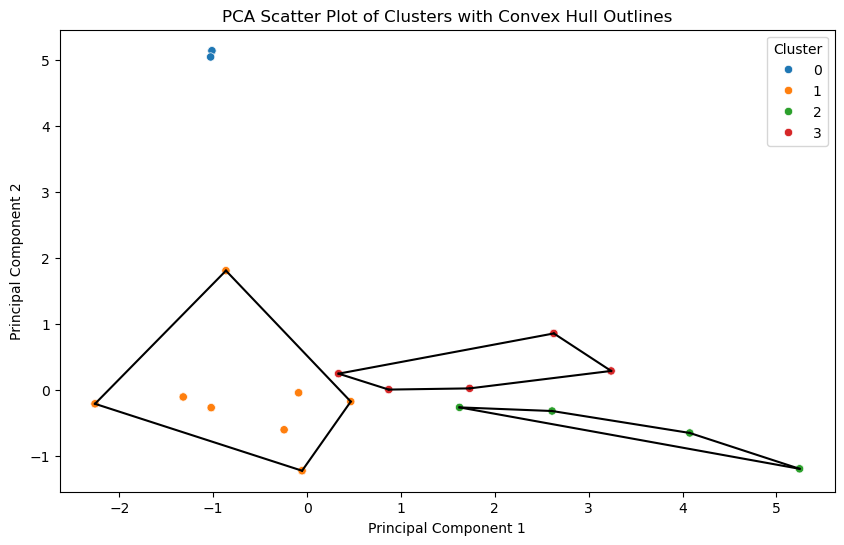

In [35]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

from scipy.spatial import ConvexHull
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='tab10', legend='full')

# Add convex hull outlines for each cluster
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster][['PC1', 'PC2']].values
    if len(cluster_data) > 2:  # ConvexHull needs at least 3 points
        try:
            hull = ConvexHull(cluster_data)
            for simplex in hull.simplices:
                plt.plot(cluster_data[simplex, 0], cluster_data[simplex, 1], 'k-')
        except:
            pass  # Skip clusters that cause ConvexHull issues

plt.title('PCA Scatter Plot of Clusters with Convex Hull Outlines')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [36]:


coefficients = nb_results.params
exponentiated_coefficients = np.exp(coefficients)  # For multiplicative interpretation
indices_nb = np.argsort(np.abs(coefficients))[::-1]



# # Plotting feature importances (coefficients)
# fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# # Raw coefficients
# axs[0].bar(range(X_corrected.shape[1]), coefficients.loc[indices_nb.index], align="center")
# axs[0].set_xticks(range(X_corrected.shape[1]))
# axs[0].set_xticklabels(X_corrected.columns[indices_nb], rotation=90)
# axs[0].set_title("Feature Importances - Negative Binomial Regression")

# # Exponentiated coefficients
# axs[1].bar(range(X_corrected.shape[1]), exponentiated_coefficients.loc[indices_nb.index], align="center")
# axs[1].set_xticks(range(X_corrected.shape[1]))
# axs[1].set_xticklabels(X_corrected.columns[indices_nb], rotation=90)
# axs[1].set_title("Feature Importances (Exponentiated Coefficients) - Negative Binomial Regression")

# plt.tight_layout()
# plt.show()


# # Extracting feature importances (coefficients)
# coefficients = results.params
# exponentiated_coefficients = np.exp(coefficients)  # For better interpretation in multiplicative terms
# indices_nb = np.argsort(np.abs(coefficients))[::-1]

# # Plotting feature importances (coefficients)
# plt.figure(figsize=(12, 6))
# plt.title("Feature Importances - Negative Binomial Regression")
# plt.bar(range(X_corrected.shape[1]), coefficients.loc[indices_nb.loc[selected_features].index], align="center")
# plt.xticks(range(X_corrected.shape[1]), X_corrected.columns[indices_nb.loc[selected_features]], rotation=90)
# plt.tight_layout()
# plt.show()

# # For better interpretation, you can also plot the exponentiated coefficients
# plt.figure(figsize=(12, 6))
# plt.title("Feature Importances (Exponentiated Coefficients) - Negative Binomial Regression")
# plt.bar(range(X_corrected[selected_features].shape[1]), exponentiated_coefficients.loc[indices_nb.loc[selected_features].index], align="center")
# plt.xticks(range(X_corrected[selected_features].shape[1]), X_corrected.columns[indices_nb.loc[selected_features]], rotation=90)
# plt.tight_layout()
# plt.show()



In [17]:
# SHAP summary plot

import shap
# X_test_corr_df = pd.DataFrame(X_test_corr, columns=X_corrected.columns)

# Prepare data for SHAP
X_test_corr_df = pd.DataFrame(X_test_corr, columns=X_corrected.columns)

# Use SHAP values for the Negative Binomial model
explainer_nb = shap.Explainer(selected_model.predict, X_test_corr, feature_names=selected_features)
# shap_values_nb = shap.TreeExplainer(results).shap_values(X_corrected)
shap_values_nb = explainer_nb(X_test_corr_df)

/home/roger/anaconda3/envs/cantonal_report/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


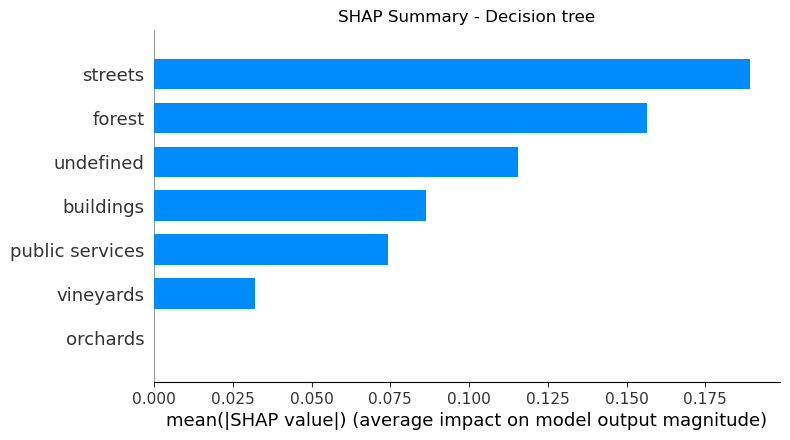

In [18]:
# Use SHAP values for the Negative Binomial model
# explainer_nb = shap.Explainer(results.predict, X_test_corr_df)
# shap_values_nb = explainer_nb(X_test_corr_df)

fig, ax = plt.subplots(figsize=(9, 6))
shap.summary_plot(shap_values_nb, X_test_corr_df, feature_names=X_corrected.columns, plot_type="bar", show=False)
plt.title("SHAP Summary - Decision tree")
plt.show()

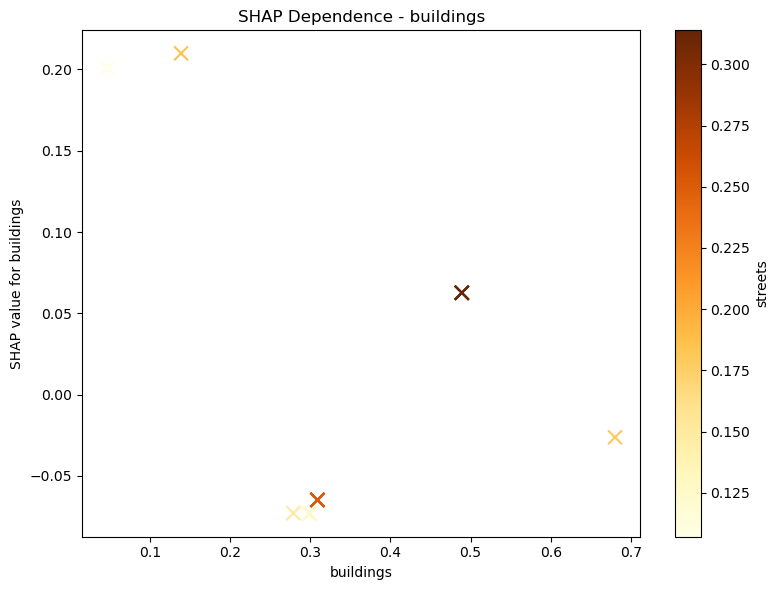

In [22]:
# Create the SHAP summary plot
fig, axs = plt.subplots(figsize=(8, 6))

# # SHAP summary plot
# axs[0] = shap.summary_plot(shap_values_nb, X_test_corr_df, feature_names=X_corrected.columns, plot_type="bar", show=False)
# axs[0].set_title("SHAP Summary - Negative Binomial")

# Manually extract SHAP values for dependence plot
feature_name = "buildings"
shap_values = shap_values_nb.values
feature_values = X_test_corr_df[feature_name]
interaction_feature = "streets"  # Choose an interaction feature
interaction_values = X_test_corr_df[interaction_feature]

# Create the dependence plot manually with color representing the interaction feature
scatter = axs.scatter(feature_values, shap_values[:, X_corrected.columns.get_loc(feature_name)], 
                         c=interaction_values, marker='x' ,cmap=plt.get_cmap("YlOrBr"),s=100, alpha=1)

# feature_name = "forest"
# shap_values = shap_values_nb.values
# feature_values = X_test_corr_df[feature_name]
# interaction_feature = "streets"  # Choose an interaction feature
# interaction_values = X_test_corr_df[interaction_feature]

# # Create the dependence plot manually with color representing the interaction feature
# scatter = axs.scatter(feature_values, shap_values[:, X_corrected.columns.get_loc(feature_name)], 
#                          c=interaction_values, marker='x' ,cmap=plt.get_cmap("YlOrBr"),s=100, alpha=0.5)
axs.set_xlabel(feature_name)
axs.set_ylabel(f"SHAP value for {feature_name}")
axs.set_title(f"SHAP Dependence - {feature_name}")
cbar = plt.colorbar(scatter, ax=axs)
cbar.set_label(interaction_feature)  # Set colorbar label to the interaction feature name

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Assuming your data is in a pandas DataFrame called 'df'
features = ['public services', 'streets', 'orchards', 'vineyards', 'buildings', 'forest', 'undefined']
X = datax[features]
y = (datax['pcs/m'] > datax['pcs/m'].median()).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different values of K
k_values = [3, 5, 7, 9, 11]
accu = 0
best_k = 1
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > accu:
        best_k = k
    print(f"Accuracy with k={k}: {accuracy:.3f}")

# Use the best K (let's say it's 5 for this example)
# best_k = 5
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)
y_pred = best_knn.predict(X_test_scaled)

print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=['Low pcs/m', 'High pcs/m']))


Accuracy with k=3: 0.850
Accuracy with k=5: 0.800
Accuracy with k=7: 0.800
Accuracy with k=9: 0.750
Accuracy with k=11: 0.750

Classification Report:


In [24]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_knn, X_test_scaled, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({'feature': features, 'importance': result.importances_mean})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))


Feature Importance:
           feature  importance
2         orchards       0.000
1          streets      -0.010
3        vineyards      -0.015
4        buildings      -0.015
5           forest      -0.025
0  public services      -0.045
6        undefined      -0.050


In [25]:
# from sklearn.tree import export_graphviz
# import graphviz

# # Export the decision tree to a dot file
# dot_data = export_graphviz(dt_regressor_corr, out_file=None, 
#                            feature_names=X_corrected.columns, 
#                            filled=True, rounded=True, 
#                            special_characters=True)

# # Use graphviz to render the dot file
# graph = graphviz.Source(dot_data)
# graph.render("decision_tree")

# Display the decision tree
graph

NameError: name 'graph' is not defined

### Explanation of SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting the predictions of machine learning models. It leverages concepts from cooperative game theory, particularly the Shapley value, to attribute the contribution of each feature to the model's prediction. SHAP values quantify the impact of each feature on the prediction by considering all possible combinations of features, ensuring a fair distribution of contribution among features. This approach not only identifies the most important features but also explains how changes in feature values influence the model's output, making it a powerful tool for model interpretability and feature importance analysis.

### Explanation of Shapley Value

In the context of game theory, the Shapley value is a solution concept used to distribute the total gains (or costs) generated by a coalition of players in a way that fairly reflects each player's contribution to the coalition. Developed by Lloyd Shapley in 1953, the Shapley value ensures that the distribution is both fair and equitable by considering every possible permutation of players joining the coalition. For each player, the Shapley value is the average marginal contribution of that player across all permutations. This means it calculates how much value a player adds to each possible coalition they could be a part of, and then averages these values to ensure a fair share.

When applied to machine learning and data, Shapley values provide a way to interpret complex model predictions by attributing the contribution of each feature to the final prediction. Each feature is treated as a "player" in a coalition, and the Shapley value represents the average contribution of that feature to the model’s prediction over all possible feature combinations. This method allows for a detailed understanding of how each feature influences the outcome, making it a robust tool for model interpretability. By considering all possible interactions among features, Shapley values ensure that the contribution of each feature is fairly assessed, regardless of the presence or absence of other features in the model.

### References

1. **Shapley, L. S. (1953). A Value for n-Person Games. Contributions to the Theory of Games, vol. 2, 307–317.** - This seminal paper by Lloyd Shapley introduces the Shapley value concept in game theory.
   
2. **Strumbelj, E., & Kononenko, I. (2014). Explaining Prediction Models and Individual Predictions with Feature Contributions. Knowledge and Information Systems, 41(3), 647-665.** - This paper discusses how Shapley values can be used to interpret predictions in machine learning.

3. **Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. Advances in Neural Information Processing Systems 30 (NIPS 2017), 4765-4774.** - This paper introduces SHAP (SHapley Additive exPlanations) and demonstrates its application to model interpretability.

4. **Molnar, C. (2019). Interpretable Machine Learning. A Guide for Making Black Box Models Explainable.** - This book provides an in-depth look at various methods for interpreting machine learning models, including SHAP.

5. **Lipovetsky, S., & Conklin, M. (2001). Analysis of Regression in Game Theory Approach. Applied Stochastic Models in Business and Industry, 17(4), 319-330.** - This paper explores the use of game theory, particularly Shapley values, in the context of regression analysis.

### Comparison of SHAP and Partial Dependence Plots (PDP)

### SHAP (SHapley Additive exPlanations)

#### Purpose:
SHAP provides a unified approach to interpreting model predictions by attributing the contribution of each feature to the final prediction. It quantifies how much each feature contributes to the prediction by considering all possible combinations of feature values, ensuring a fair distribution of contributions among features.

#### How It Works:
- **Game Theory Basis**: SHAP values are based on the Shapley value concept from cooperative game theory, which ensures a fair allocation of the total gain (or prediction) among features.
- **Local Interpretability**: SHAP values explain individual predictions by showing the impact of each feature on that specific prediction.
- **Global Interpretability**: Aggregating SHAP values across many predictions provides insights into overall feature importance and interactions.
- **Fairness**: By considering all possible subsets of features, SHAP values ensure that each feature's contribution is fairly assessed in the presence of other features.

#### Strengths:
- **Model-Agnostic**: SHAP can be applied to any machine learning model.
- **Detailed Explanations**: Provides both local and global interpretability.
- **Interaction Effects**: Captures interactions between features.

#### Limitations:
- **Computationally Intensive**: Calculating SHAP values can be time-consuming, especially for large datasets and complex models.

### Partial Dependence Plots (PDP)

#### Purpose:
PDPs are used to visualize the effect of one or two features on the predicted outcome of a machine learning model. They show the average predicted outcome as a function of the feature(s) of interest, while averaging out the effects of other features.

#### How It Works:
- **Marginal Effect**: PDPs plot the marginal effect of a feature by keeping other features constant or averaging their effects.
- **Global Interpretability**: They provide a global view of how the feature(s) influence predictions across the entire dataset.
- **Visualization**: PDPs are typically visualized as line or contour plots (for one or two features).

#### Strengths:
- **Simplicity**: Easy to interpret and visualize.
- **Computationally Efficient**: Less computationally intensive compared to SHAP.
- **Clear Effect**: Provides a clear view of the main effect of a feature on the prediction.

#### Limitations:
- **Assumes Independence**: Assumes that the feature of interest is independent of other features, which might not hold in practice.
- **Limited Interaction Insight**: While PDPs can show interaction effects (with two features), they are less comprehensive than SHAP in capturing complex interactions.

### Key Differences

1. **Interpretability Scope**:
   - **SHAP**: Provides both local (individual prediction) and global (overall model behavior) interpretability.
   - **PDP**: Primarily provides global interpretability, showing the average effect of a feature across the dataset.

2. **Feature Interactions**:
   - **SHAP**: Captures complex interactions between features.
   - **PDP**: Can capture interactions between two features, but generally assumes feature independence for single-feature plots.

3. **Computational Complexity**:
   - **SHAP**: More computationally intensive due to the need to consider all possible feature combinations.
   - **PDP**: Less computationally intensive, averaging out effects of other features.

4. **Model Dependency**:
   - **SHAP**: Model-agnostic and can be applied to any machine learning model.
   - **PDP**: Typically implemented within specific frameworks like scikit-learn.

### Example Use Cases

- **SHAP**: Best used when detailed explanations of individual predictions are needed, or when understanding complex feature interactions is crucial.
- **PDP**: Useful for gaining a general understanding of how specific features influence predictions on average, especially in simpler models or as an initial step in model interpretation.

### Conclusion

Both SHAP and PDP are valuable tools for interpreting machine learning models, but they serve different purposes and have different strengths and limitations. SHAP provides a more detailed and comprehensive view, especially useful for understanding individual predictions and feature interactions, while PDP offers a simpler and computationally efficient way to visualize the average effect of features on model predictions.